# Global Model-Agnostic Interpretation Methods

In [1]:
import math
import os, random
import numpy as np
import pandas as pd
import machine_learning_datasets as mldatasets

from sklearn import metrics, ensemble, tree, inspection, model_selection
import catboost as cb

import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns
import shap
from pdpbox import pdp, info_plots
from PyALE import ale
from lime.lime_tabular import LimeTabularExplainer

## Data

### Load data

In [7]:
usedcars_df = mldatasets.load("usedcars", prepare=True)
usedcars_df.info()

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python-2E/raw/main/datasets/usedcars-2e.csv.zip downloaded to /home/keren/Interpretable-ML/notebooks/data/usedcars-2e.csv.zip
/home/keren/Interpretable-ML/notebooks/data/usedcars-2e.csv.zip uncompressed to /home/keren/Interpretable-ML/notebooks/data/usedcars-2e.csv
1 dataset files found in /home/keren/Interpretable-ML/notebooks/data/usedcars-2e.csv folder
parsing /home/keren/Interpretable-ML/notebooks/data/usedcars-2e.csv/usedcars_imputed.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 256065 entries, 7316814884 to 7302338378
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   price                            256065 non-null  int64  
 1   region                           256065 non-null  object 
 2   posting_date                     256065 non-null  object 
 3   lat                              25606

### Data preparation

Apply categorical encoding, only if category has at least 500 records.

In [8]:
usedcars_orig_df = usedcars_df.copy()
usedcars_df = mldatasets.make_dummies_with_limits(usedcars_df, 'fuel',\
                                                  min_recs=500, defcatname='other')
usedcars_df = mldatasets.make_dummies_with_limits(usedcars_df, 'make_cat')
usedcars_df = mldatasets.make_dummies_with_limits(usedcars_df, 'model_type',\
                                                  min_recs=500, defcatname='other')
usedcars_df = mldatasets.make_dummies_with_limits(usedcars_df, 'condition',\
                                                  min_recs=200, defcatname='other')
usedcars_df = mldatasets.make_dummies_with_limits(usedcars_df, 'drive')
usedcars_df = mldatasets.make_dummies_with_limits(usedcars_df, 'title_status',\
                                                  min_recs=500, defcatname='other')

Object columns

In [9]:
usedcars_df.dtypes[lambda x: x == object].index.tolist()

['region', 'posting_date', 'state', 'city', 'zip', 'make', 'model']

We will drop them as we have information about location in other features (like longitude and latitude).

In [10]:
usedcars_df = usedcars_df.select_dtypes(include=(int,float,np.uint8))

### Train test split

In [11]:
rand = 42
os.environ['PYTHONHASHSEED'] = str(rand)
np.random.seed(rand)
random.seed(rand)

target_col = 'price'

X = usedcars_df.drop([target_col], axis=1)
y = usedcars_df[target_col]

X_train, X_test, y_train, y_test =\
        model_selection.train_test_split(X, y, test_size=0.25, random_state=rand)

## Models training

In [12]:
cb_mdl = cb.CatBoostRegressor(depth=7, learning_rate=0.2, random_state=rand, verbose=False)
cb_mdl.fit(X_train, y_train)

rf_mdl = ensemble.RandomForestRegressor(n_jobs=-1, random_state=rand)
rf_mdl = rf_mdl.fit(X_train.to_numpy(), y_train.to_numpy())

Evaluation of CatBoost model using regression plot

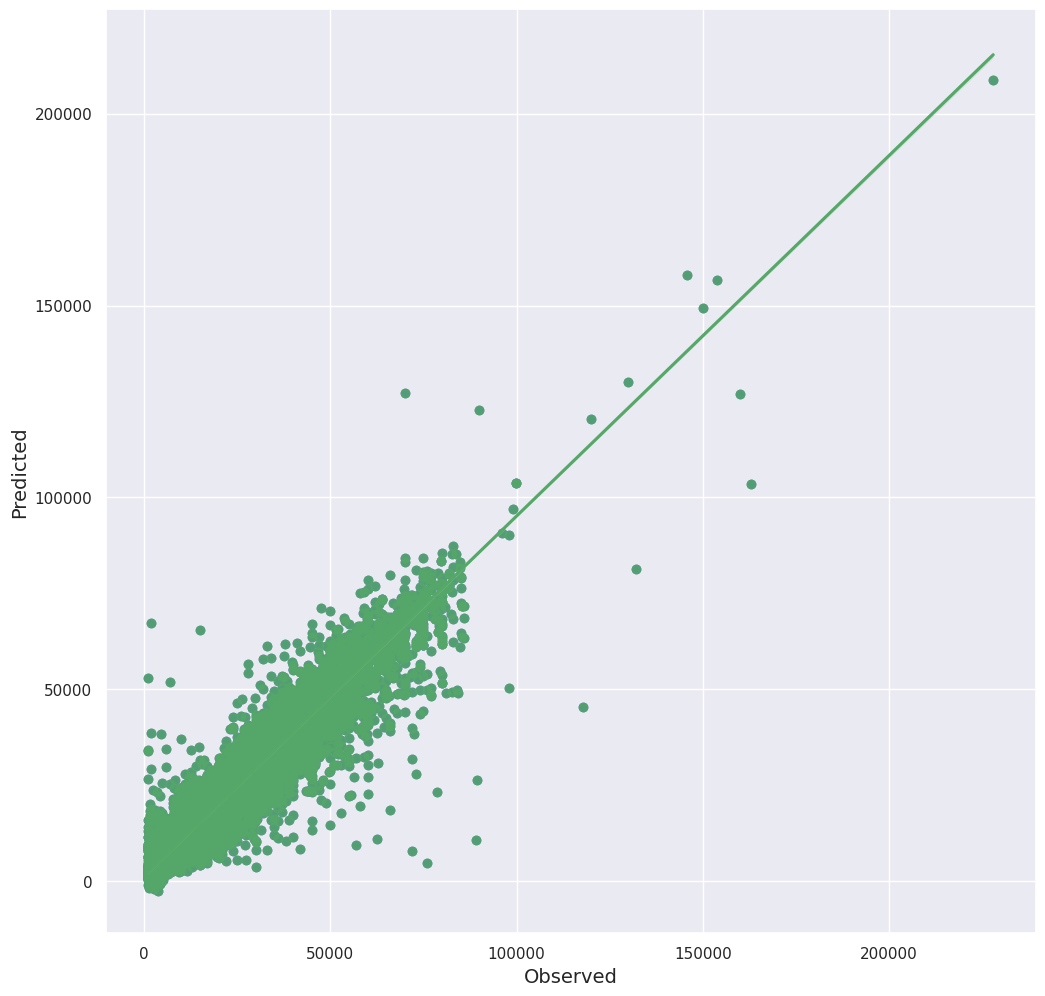

RMSE_train: 2543.4672	RMSE_test: 3099.8195	r2: 0.9444


In [13]:
mdl = cb_mdl

sns.set_theme()
y_train_pred, y_test_pred =\
        mldatasets.evaluate_reg_mdl(mdl, X_train, X_test, y_train, y_test)

There are a few cases with high errors, but vast majority of the samples were predicted with fairly small error.

In [14]:
thresh = 4000
pct_under = np.where(np.abs(y_test - y_test_pred) < thresh, 1, 0).sum() / len(y_test)
print(f"Percentage of test samples under ${thresh:,.0f} in absolute error {pct_under:.1%}")

Percentage of test samples under $4,000 in absolute error 89.9%


Evaluation of Random Forest model using regression plot

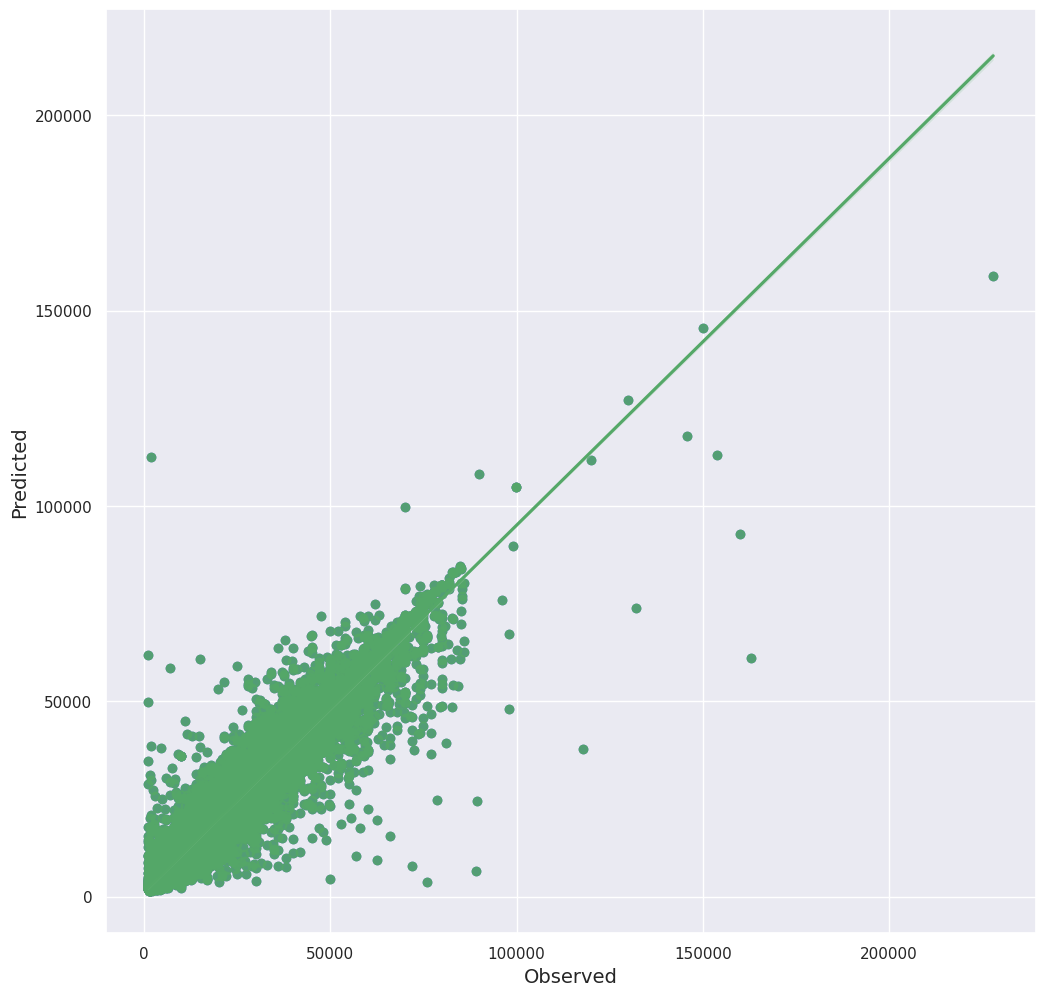

RMSE_train: 1158.2029	RMSE_test: 3074.9148	r2: 0.9453


In [15]:
mdl = rf_mdl

sns.set_theme()
y_train_pred, y_test_pred =\
        mldatasets.evaluate_reg_mdl(mdl, X_train, X_test, y_train, y_test)

Random forest model overfits much more than CatBoost.

In [16]:
thresh = 4000
pct_under = np.where(np.abs(y_test - y_test_pred) < thresh, 1, 0).sum() / len(y_test)
print(f"Percentage of test samples under ${thresh:,.0f} in absolute error {pct_under:.1%}")

Percentage of test samples under $4,000 in absolute error 91.4%


## Feature importance

Feature importance refers tot he extent to which each feature contributes to the final output of a model.

Features used in top splits of RF model. As it is an ensemble model, feature importance is the mean decrease in impurity across all estimators. How much feature decreases model impurity indicates how much it contributes to the model's outcome.

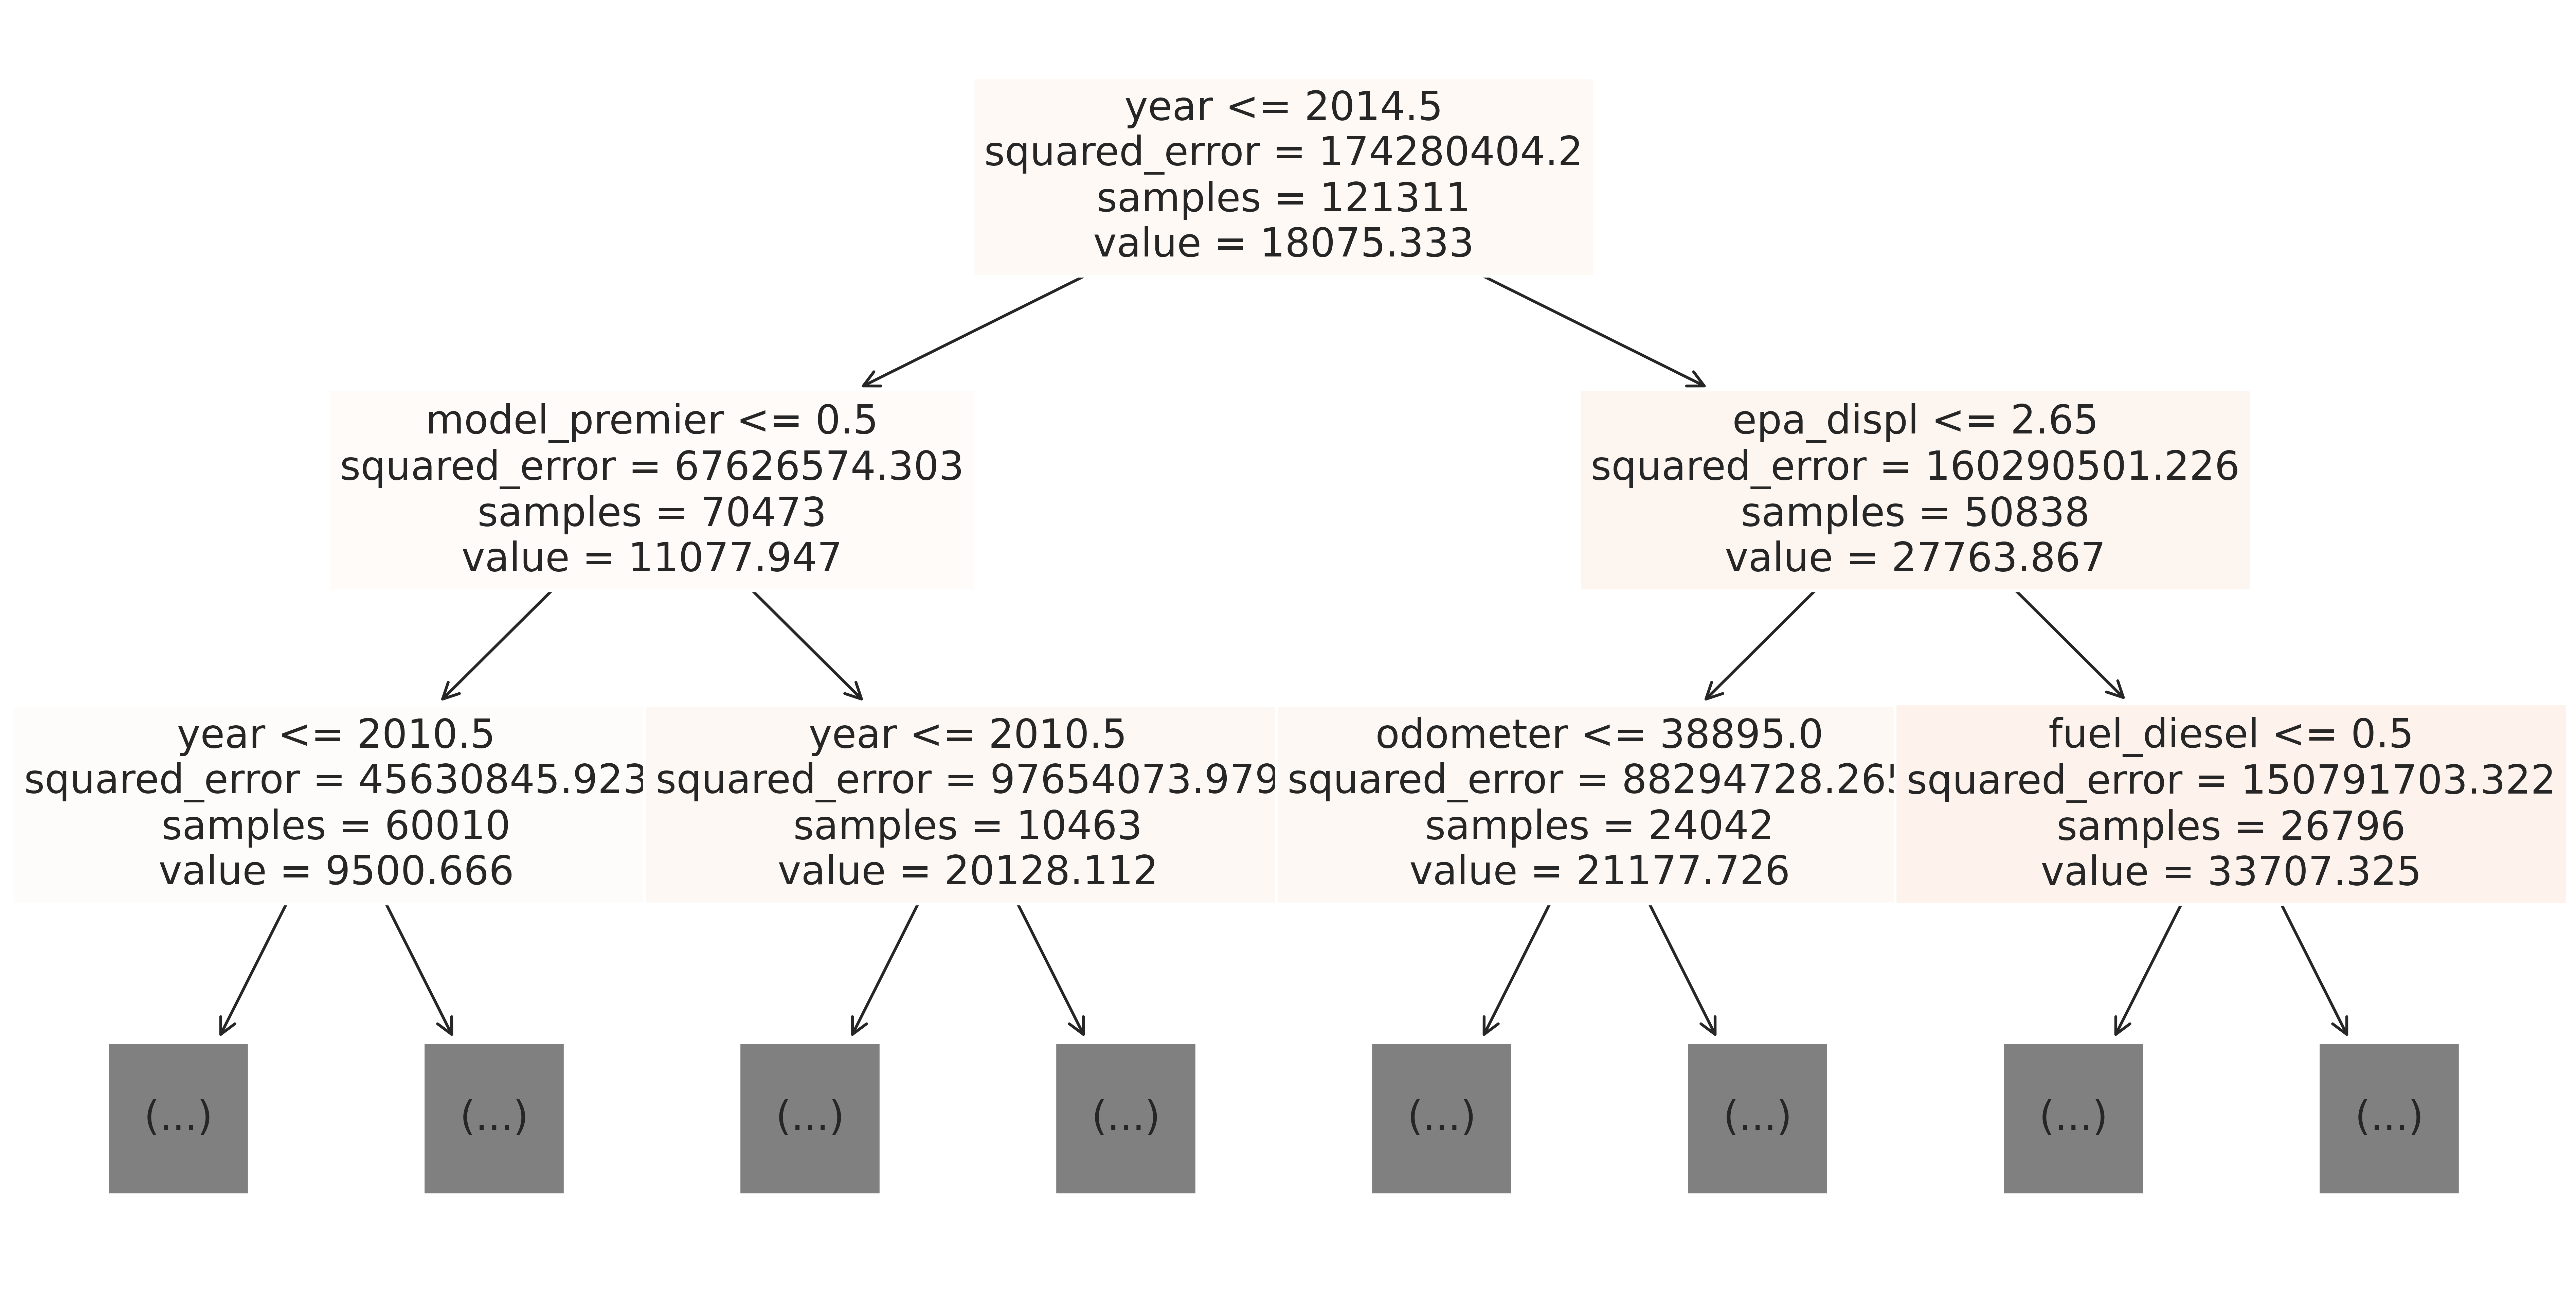

In [17]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(rf_mdl.estimators_[0], feature_names=X_train.columns,\
               filled = True, max_depth=2, fontsize=14)
fig.show()

Feature importance for RF

In [18]:
rf_feat_imp = rf_mdl.feature_importances_
print(rf_feat_imp)

[8.27435826e-03 1.05316891e-02 2.41376641e-02 5.91421757e-02
 4.59888312e-01 2.36497116e-02 1.73254921e-02 9.41039384e-02
 1.13595842e-03 2.44903039e-02 1.52845147e-02 1.17932359e-01
 6.68909617e-03 7.26970607e-03 6.49519448e-03 3.73906562e-02
 3.35077351e-05 2.08595484e-03 1.06105564e-04 7.35524118e-04
 3.71629481e-03 1.37587550e-03 3.62514722e-05 1.35433058e-03
 1.85942291e-02 2.25594767e-03 4.58569071e-04 5.88135573e-04
 1.17333990e-04 3.57957275e-04 1.04637636e-03 1.85825529e-02
 3.04228803e-03 2.76059120e-03 6.61424708e-04 6.88477978e-05
 1.32533130e-03 5.57300537e-04 7.98286843e-03 7.95490983e-04
 1.21376943e-04 2.40284349e-05 1.40877926e-03 5.16139425e-03
 5.76593121e-03 1.65879364e-03 1.98557685e-03 1.89424809e-04
 3.60991098e-05 6.94700818e-04 2.98266787e-04 2.75408128e-04]


Feature importance for CB

In [19]:
cb_feat_imp = cb_mdl.feature_importances_
print(cb_feat_imp)

[1.23241338e+00 1.47250731e+00 5.10854175e+00 5.06215588e+00
 2.32428685e+01 2.49396877e+00 2.34425124e+00 1.30525170e+01
 3.62293240e-01 5.05852371e+00 4.02843847e+00 9.94625509e+00
 5.91470586e-01 6.56065556e-01 6.44118827e-01 6.15577710e+00
 4.52983204e-03 4.43591782e-01 1.97928036e-02 1.13317838e-01
 9.36855026e-01 7.15847753e-01 1.45702595e-02 1.50436254e-01
 3.20122608e+00 4.66538937e-01 4.35409660e-02 5.65100050e-02
 1.20649331e-02 7.26020698e-02 2.57216240e-01 3.41471177e+00
 8.61301597e-01 4.76814546e-01 1.41586247e-01 1.53973282e-02
 7.93089927e-02 1.52855942e-01 1.92784381e+00 9.89543927e-02
 5.87334128e-03 6.15126282e-03 4.08901733e-01 8.85913922e-01
 2.52940402e+00 3.18871605e-01 2.40918949e-01 2.57587858e-02
 3.64708812e-03 2.48937147e-01 1.27365951e-01 6.86744613e-02]


In [20]:
feat_imp_df = pd.DataFrame({'feature':X_train.columns, 'cb_feat_imp':cb_feat_imp,\
                            'rf_feat_imp':rf_feat_imp*100})
feat_imp_df = feat_imp_df.sort_values('cb_feat_imp', ascending=False)
feat_imp_df.style.format('{:.2f}%', subset=['cb_feat_imp', 'rf_feat_imp']).\
                bar(subset=['cb_feat_imp', 'rf_feat_imp'], color='#4EF', width=60)

,feature,cb_feat_imp,rf_feat_imp
4,year,23.24%,45.99%
7,odometer,13.05%,9.41%
11,epa_displ,9.95%,11.79%
15,fuel_diesel,6.16%,3.74%
2,make_pop,5.11%,2.41%
3,model_premier,5.06%,5.91%
9,cylinders,5.06%,2.45%
10,epa_co2,4.03%,1.53%
31,model_type_pickup,3.41%,1.86%
24,make_cat_regular,3.20%,1.86%


## Assessing feature importance with model-agnostic methods

### Permutation feature importance

After training model we cannot remove a feature, but we can:

* replace feature with a static value (mean or median)
* shuffle the feature values to disrupt the relationship between the feature and outcome

The second strategy is used below. Decrease in negative MAE when the feature is shuffled would suggest that the feature has a high influence on the prediction.

In [21]:
%%time
X_samp = X_test.sample(frac=0.3)
y_samp = y_test.loc[X_samp.index]

cb_perm_imp = inspection.permutation_importance(cb_mdl, X_samp, y_samp,\
                                                n_repeats=5, random_state=rand,\
                                                scoring='neg_mean_absolute_error')
rf_perm_imp = inspection.permutation_importance(rf_mdl, X_samp.to_numpy(),\
                                                y_samp.to_numpy(), n_repeats=5,\
                                                random_state=rand, scoring='neg_mean_absolute_error')

CPU times: user 13min 14s, sys: 17.3 s, total: 13min 31s
Wall time: 1min 6s


In [22]:
perm_imp_df = pd.DataFrame({'feature':X_train.columns, 'cb_perm_mean':cb_perm_imp.importances_mean,\
                            'cb_perm_std':cb_perm_imp.importances_std,\
                            'rf_perm_mean':rf_perm_imp.importances_mean,\
                            'rf_perm_std':rf_perm_imp.importances_std})
perm_imp_df = perm_imp_df.sort_values('cb_perm_mean', ascending=False)
perm_imp_df.style.format('{:.4f}', subset=['cb_perm_mean', 'cb_perm_std', 'rf_perm_mean', 'rf_perm_std']).\
                bar(subset=['cb_perm_mean', 'rf_perm_mean'], color='#4EF', width=60)

,feature,cb_perm_mean,cb_perm_std,rf_perm_mean,rf_perm_std
4,year,5469.6114,17.8537,6381.3891,14.3311
7,odometer,3029.2987,16.3274,3289.6996,22.4841
11,epa_displ,1330.7051,16.0213,2191.0799,25.1505
9,cylinders,1049.3324,10.0008,1217.5801,16.4082
2,make_pop,996.2043,7.1443,521.5881,6.8384
3,model_premier,580.0383,13.7382,1149.4696,15.5622
10,epa_co2,558.8655,3.1452,720.9986,14.3755
31,model_type_pickup,548.2176,8.2829,539.4135,4.2696
5,make_yr_pop,546.1205,3.6921,488.1375,6.4764
24,make_cat_regular,483.7597,5.6140,703.0490,12.2885


Permutation feature importance can be understood as the average increase in model error when a feature is made irrelevant, along with its interactions with other features.

## SHAP values

SHAP is an implementation of [Shapley values](https://christophm.github.io/interpretable-ml-book/shapley.html).

A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

Kernel Explainer can be used to estimate SHAP values. As it is consuming process it is done only on a small subset of the data, but bigger chunk of data gives better estimations.

In [24]:
%%time
rf_fn = lambda x: rf_mdl.predict(x)
X_train_summary = shap.kmeans(X_train.to_numpy(), 50)
X_test_sample = X_test.sample(frac=0.02)

rf_kernel_explainer = shap.KernelExplainer(rf_fn, X_train_summary)
rf_shap_values = rf_kernel_explainer.shap_values(X_test_sample.to_numpy(),\
                                                 nsamples=100) 

  0%|          | 0/1280 [00:00<?, ?it/s]

CPU times: user 8min 29s, sys: 3min 22s, total: 11min 51s
Wall time: 4min 31s


In [28]:
print(X_test_sample.shape)
print(rf_shap_values.shape)

(1280, 52)
(1280, 52)


### Faster Explanations with TreeExplainer

Tree Explainer was designed to efficiently estimate SHAP values for tree based methods like: CART, Random Forest, XGBoost or CatBoost.

In [26]:
%%time
cb_tree_explainer = shap.TreeExplainer(cb_mdl)
cb_shap_values = cb_tree_explainer.shap_values(X_test)

CPU times: user 42.1 s, sys: 604 ms, total: 42.7 s
Wall time: 4.51 s


In [27]:
cb_shap_imp = np.mean(np.abs(cb_shap_values),0)
rf_shap_imp = np.mean(np.abs(rf_shap_values),0)

shap_imp_df = pd.DataFrame({'feature':X_train.columns, 'cb_shap_imp':cb_shap_imp,\
                            'rf_shap_imp':rf_shap_imp})
shap_imp_df = shap_imp_df.sort_values('cb_shap_imp', ascending=False)
shap_imp_df.style.format('{:.4f}', subset=['cb_shap_imp', 'rf_shap_imp']).\
                bar(subset=['cb_shap_imp', 'rf_shap_imp'], color='#4EF', width=60)

,feature,cb_shap_imp,rf_shap_imp
4,year,5374.6635,5741.4506
7,odometer,3691.2966,2883.8135
11,epa_displ,1347.3157,1874.2318
9,cylinders,1125.1109,792.3454
3,model_premier,1123.7732,647.0335
2,make_pop,865.3036,381.4968
31,model_type_pickup,861.0232,645.2464
44,drive_fwd,837.2566,285.1025
24,make_cat_regular,767.6872,407.4443
15,fuel_diesel,676.5713,420.7247


## Visualize Global explanations

In [29]:
cb_explainer = shap.Explainer(cb_mdl)
cb_shap = cb_explainer(X_test)

In [31]:
print(type(cb_explainer))

<class 'shap.explainers._tree.TreeExplainer'>


In [32]:
print("Values dimensions: %s" % (cb_shap.values.shape,)) 
print("Data dimensions:   %s" % (cb_shap.data.shape,))

Values dimensions: (64017, 52)
Data dimensions:   (64017, 52)


### SHAP bar plot

It is the most straight forward explanation of feature importance we can do. It shows the average of the absolute value of SHAP values for each feature.

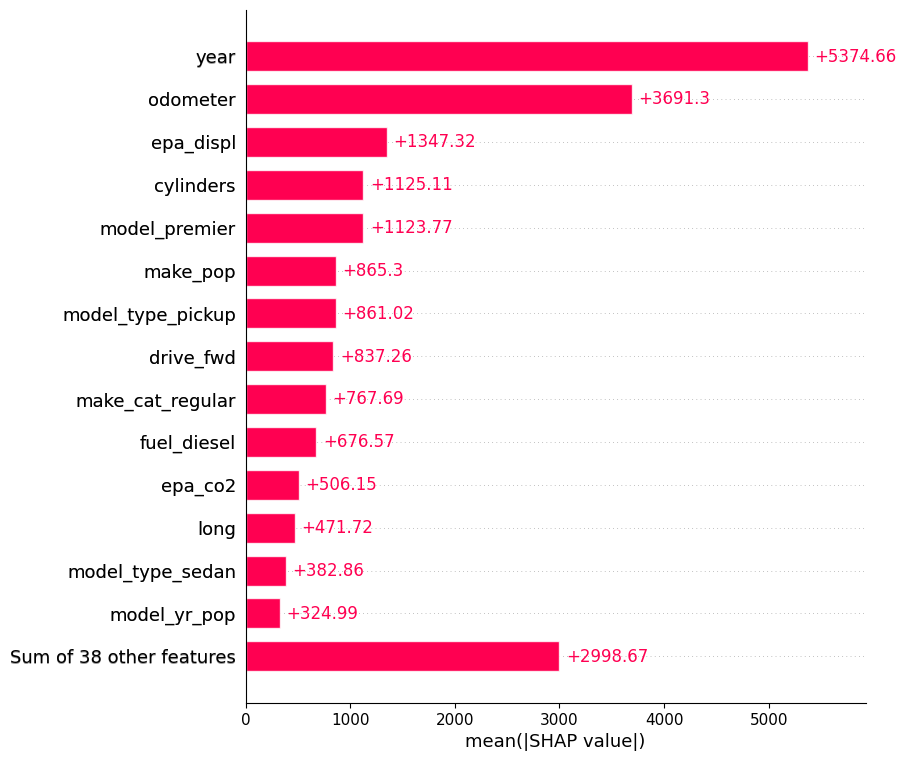

In [33]:
sns.reset_orig()
shap.plots.bar(cb_shap, max_display=15) 

Feature importance across different groups.

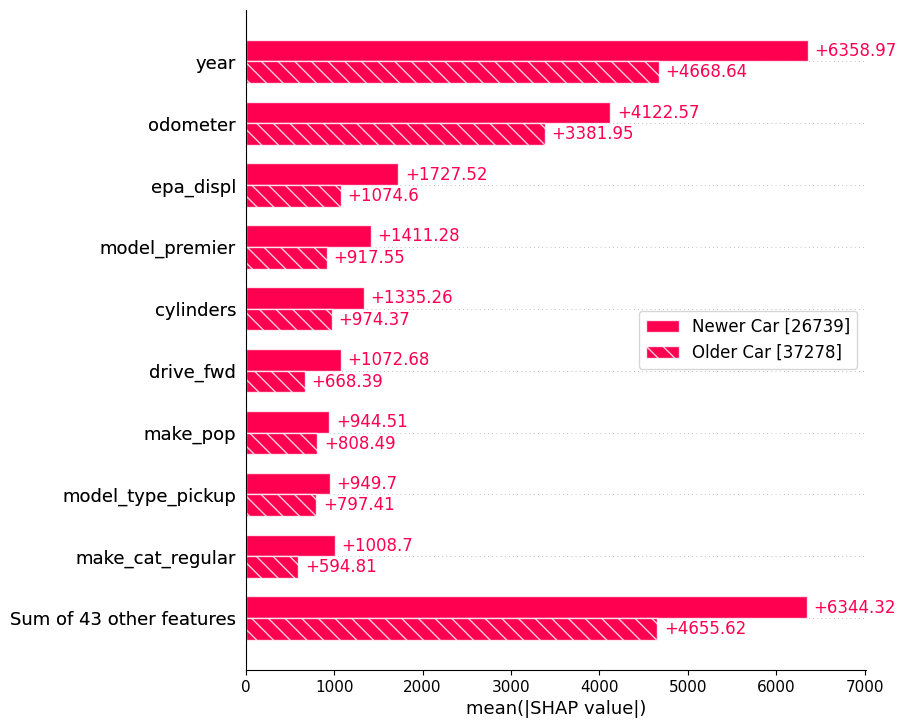

In [34]:
yr_cohort = np.where(X_test.year > 2014,\
                     "Newer Car", "Older Car")

shap.plots.bar(cb_shap.cohorts(yr_cohort).abs.mean(0))

### SHAP Beeswarm Plot

The distribution across all observations can also exhibit considerable variation. Beeswarm plots provide more insight ny showing observation for every individual feature.

Dots are color coded based on their position in the range of low to high values for each feature. They are arranged horizontally according to their impact on the outcome, centered on the line where SHAP=0, with negative on the left and positive on the right. Dots accumulate vertically, creating a histogram-like visualization to display the number of observations influencing the outcome at every impact level for each feature.


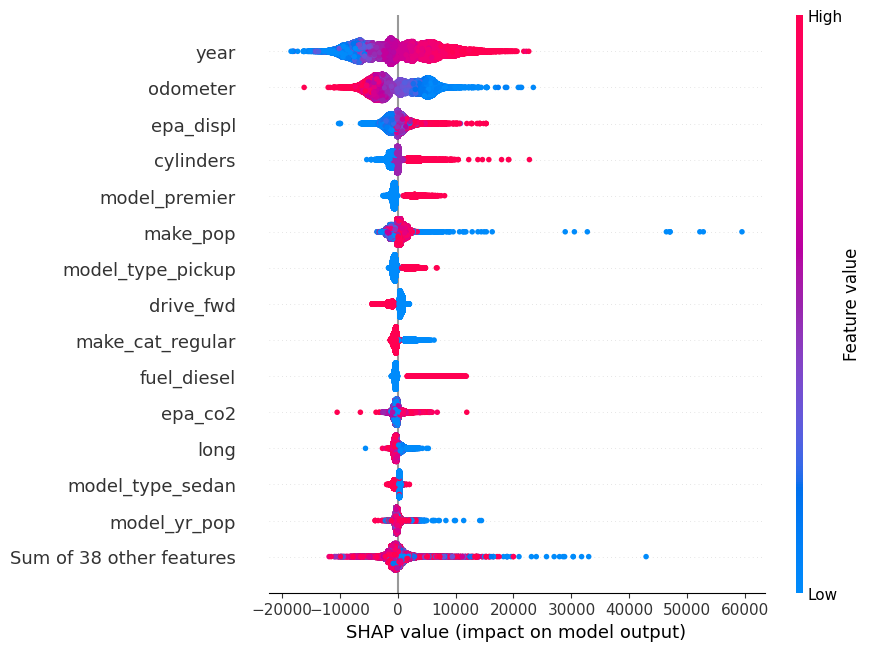

In [35]:
shap.plots.beeswarm(cb_shap, max_display=15)